# Bonus assignement

## Instructions
- Your submission should be the `.ipynb` file with your name,
  like `FirstNameLastName.ipynb`. It should include the answers to the questions in
  markdown cells.
- You are expected to follow the best practices for code writing and model
training. Poor coding style will be penalized.
- You are allowed to discuss ideas with your peers, but no sharing of code.
Plagiarism in the code will result in failing. If you use code from the
internet, cite it. 
- Read each instruction carefully and provide complete answers to each question/task
- You are allowed to use Keras or Pytorch 

> **_NOTE:_**  Write your email address in the cell below

a.vagin@innopolis.university

### I- Open questions (3 points)

Read [this article](https://link.springer.com/referenceworkentry/10.1007/978-0-387-73003-5_304) and answer the following questions:

1. What is incremental learning?
    - Incremental learning is a technique when we do not train our models on the whole data. We learn our model incrementally adding understanding of the new incoming data. There may be several reasons for this, for example, all the data does not fit completely into memory, or we got new data and it is to expensive to retrain the model from scratch, also there are a lot of applications where data is beeing generated over time.
2. Why is it important for us to create neural networks that would someday be able to learn incrementally?
    - With help of machine learning we want to solve real problems that appear in our world, but this world and it's problems change over time One day we can meet some new context for our task or some new but similar challenge will appear and we will want to solve it.

    - Incremental learning is like adaption mechanizm for machine leraning models and we need this adaption for successful completion of tasks in real world as it cnanges.
3. What is catastrophic forgetting?
    - It is a tendency of ANNs to forget previously learned dependencies while learning new inforamtion.

### II- Train simple CNN model for digit classification (5 points)

Instructions:
- Load MNIST dataset and split it in **Tr**ainning (`Tr`) and **Te**ting set (`Te`), 80% and 20% respectively.
- Train a simple CNN for digit classification on the training set. 
- After fine tuning your CNN, evaluate the `overall` and the `class-wise` performances on `Te`. 
>**NOTE:** For the class-wise performance, you should plot (e.g., bar plots) the performance of your model on each class.

In [1]:
import torch
import torchvision
from torchvision import transforms
# from torchsummary import summary
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader

from torchvision import transforms as tfs
from torchvision.datasets import MNIST

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import clear_output

device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [25]:
data_tfs = tfs.Compose([
    tfs.ToTensor(),
    tfs.Normalize((0.5), (0.5))
])

# install for train and test
root = './'
train_dataset = MNIST(root, train=True,  transform=data_tfs, download=True)
val_dataset  = MNIST(root, train=False, transform=data_tfs, download=True)

batch_size = 4

train_dataloader =  DataLoader(train_dataset, batch_size=batch_size, drop_last=True)
valid_dataloader =  DataLoader(val_dataset, batch_size=batch_size, drop_last=True)

In [37]:
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 3)
        self.pool1 = nn.MaxPool2d(2)
        self.conv2 = nn.Conv2d(6, 16, 3)
        self.pool2 = nn.MaxPool2d(2)
        self.fc1 = nn.Linear(400, 120) 
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool1(F.relu(self.conv1(x)))
        x = self.pool2(F.relu(self.conv2(x)))
        #print(x.shape)
        x = x.view(-1, 400)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [30]:
def train_model(
        model, 
        model_name,
        train_loader, 
        valid_loader,
        num_epochs=10,
        print_res=False):
    
    # model.double()
    model = model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.AdamW(model.parameters())

    loaders = {"train": train_loader, "valid": valid_loader}
    accuracy = {"train": [], "valid": []}
    best_accuracy = 0


    for epoch in range(num_epochs):
        if print_res == False:
            clear_output()
        print(f'\nEpoch: {epoch + 1}')
        for k, dataloader in loaders.items():
            epoch_correct = 0
            epoch_all = 0

            for x_batch, y_batch in dataloader:

                x_batch = x_batch.to(device)
                y_batch = y_batch.to(device)

                if k == "train":
                    model.train()
                    optimizer.zero_grad()
                    outp = model(x_batch)
                else:
                    model.eval()
                    with torch.no_grad():
                        outp = model(x_batch)

                preds = outp.argmax(-1)
                correct = (preds == y_batch).sum()
                all = len(outp)
                epoch_correct += correct.item()
                epoch_all += all

                if k == "train":
                    loss = criterion(outp, y_batch)
                    loss.backward()
                    optimizer.step()

            print(f"Loader: {k}. Accuracy: {round(epoch_correct / epoch_all, 4)}")

            accuracy[k].append(epoch_correct / epoch_all)

            if k == 'valid' and accuracy['valid'][-1] > best_accuracy:
                torch.save(model.state_dict(), f'./models/{model_name}.pt')
                best_accuracy = accuracy['valid'][-1]

    print('\nBest accuracy:\n')
    print('train:', round(max(accuracy['train']), 4))
    print('test:', round(max(accuracy['valid']), 4))
    model.load_state_dict(torch.load(f'./models/{model_name}.pt', map_location=device))

In [5]:
lenet = LeNet()

train_model(lenet, 'LeNet', train_dataloader, valid_dataloader, num_epochs=5)


Epoch: 5
Loader: train. Accuracy: 0.9759
Loader: valid. Accuracy: 0.9702

Best accuracy:

train: 0.9759
test: 0.9702


I got overall accuracy equal to 0.9702. Let's watch classwise accuracy.

In [79]:
def measure_accuracy(model, shift=0, valid_loader=valid_dataloader):
    class_correct = np.zeros(10)
    class_total = np.zeros(10)

    with torch.no_grad():
        for data in valid_loader:
            images, labels = data
            y_pred = model(images.to(device))
            _, predicted = torch.max(y_pred, 1)

            predicted += shift
            
            c = (predicted.cpu().detach() == labels)
            for i in range(batch_size):
                label = labels[i]
                class_correct[label] += c[i].item()
                class_total[label] += 1


    for i in range(10):
        print('Accuracy of %2s : %2d%%' % (i, 100 * class_correct[i] / class_total[i]))

    accuracy = [100 * class_correct[i] / class_total[i] for i in range(10)]

    return accuracy

In [46]:
accuracy = measure_accuracy(lenet)

Accuracy of  0 : 99%
Accuracy of  1 : 99%
Accuracy of  2 : 97%
Accuracy of  3 : 98%
Accuracy of  4 : 97%
Accuracy of  5 : 97%
Accuracy of  6 : 97%
Accuracy of  7 : 91%
Accuracy of  8 : 96%
Accuracy of  9 : 96%


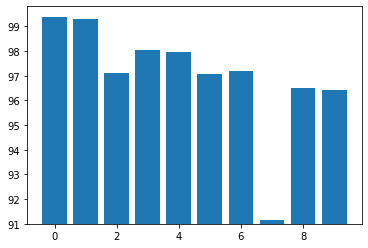

In [83]:
bottom = 91
plt.bar(range(10), [acc - bottom for acc in accuracy], bottom=bottom)
plt.show()

As we can see I got the worst accuracy for the `7` label.

### III- Create different tasks from the MNIST dataset (2 points)

Split `Tr` into 3 datasets (tasks) according to the following distribution.

- Task 1 contains digits of classes 0, 1, and 2. 
- Task 2 contains classes 3, 4, and 5. 
- Task 3 contains classes 6, 7, 8, and 9.
 
*The following picture showcases the general scheme*
<center>
<img src='https://drive.google.com/uc?id=1vdDgdN9BGQ2Jl3Yg4YiPvfb5fcAeJZJ-' style="width:500px;"> 
</center>


In [56]:
train_dataset_012 = []

for image, label in train_dataset:
    if label == 0 or label == 1 or label == 2:
        train_dataset_012.append((image, label))


val_dataset_012 = []

for image, label in val_dataset:
    if label == 0 or label == 1 or label == 2:
        val_dataset_012.append((image, label))

In [57]:
train_dataset_345 = []

for image, label in train_dataset:
    if label == 3 or label == 4 or label == 5:
        train_dataset_345.append((image, label - 3))


val_dataset_345 = []

for image, label in val_dataset:
    if label == 3 or label == 4 or label == 5:
        val_dataset_345.append((image, label - 3))

In [58]:
train_dataset_6789 = []

for image, label in train_dataset:
    if label == 6 or label == 7 or label == 8 or label == 9:
        train_dataset_6789.append((image, label - 6))


val_dataset_6789 = []

for image, label in val_dataset:
    if label == 6 or label == 7 or label == 8 or label == 9:
        val_dataset_6789.append((image, label - 6))

In [59]:
batch_size = 4

train_dataloader_012 =  DataLoader(train_dataset_012, batch_size=batch_size, drop_last=True)
valid_dataloader_012 =  DataLoader(val_dataset_012, batch_size=batch_size, drop_last=True)

train_dataloader_345 =  DataLoader(train_dataset_345, batch_size=batch_size, drop_last=True)
valid_dataloader_345 =  DataLoader(val_dataset_345, batch_size=batch_size, drop_last=True)

train_dataloader_6789 =  DataLoader(train_dataset_6789, batch_size=batch_size, drop_last=True)
valid_dataloader_6789 =  DataLoader(val_dataset_6789, batch_size=batch_size, drop_last=True)

### IV- Class-incremental learning implementation (8 points)

Using the different tasks (datasets) you created previously, implement a CNN for class incremental learning according to the following instructions. 
- The neural network architecture is not given, choose and tune your architecture following DNNs best practices. Similarly for the training no hyperparameters are given to you, you should choose them and justify your choice. Hyperparameter tuning is not mandatory but doing it would be a plus.
- Your network should have shared feature extractor (shared layers) part and separate classifier head (e.g., fully connected layers) for each task (see the figure below).
- When training on a new task, the shared layers part will get updated along with the head of the current task. 
- After training each task (Task 1 & 2), evaluate (and plot) the performances of the current and the previous tasks on `Te`.
    - Once the training on the last task is complete, test the model on `Te` and compare the performance of the network with the CNN trained in II, i.e., plot the `overall` and the `class-wise` performances for classical learning and incremental learning.

<center>
<img src='https://drive.google.com/uc?id=1HfwcMP7jGoJnYEMu7jDqloQNogEZsjrJ'  style="width:250px;"> 
</center>


#### Model

In [53]:
features = nn.Sequential(
    nn.Conv2d(1, 6, 3),
    nn.MaxPool2d(2),
    nn.Conv2d(6, 16, 3),
    nn.MaxPool2d(2)
)

class Model(nn.Module):
    def __init__(self, features, output_size):
        super(Model, self).__init__()

        self.features = features

        self.classifier = nn.Sequential(
            nn.Linear(400, 120),
            nn.Linear(120, 84),
            nn.Linear(84, output_size)
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(-1, 400)
        x = self.classifier(x)

        return x

#### Task 1

In [54]:
model_012 = Model(features, output_size=3)

train_model(model_012, 'task1', train_dataloader_012, valid_dataloader_012, num_epochs=5)


Epoch: 5
Loader: train. Accuracy: 0.9961
Loader: valid. Accuracy: 0.9946

Best accuracy:

train: 0.9961
test: 0.9949


In [55]:
accuracy_012 = measure_accuracy(model_012)

Accuracy of  0 : 99%
Accuracy of  1 : 100%
Accuracy of  2 : 98%
Accuracy of  3 :  0%
Accuracy of  4 :  0%
Accuracy of  5 :  0%
Accuracy of  6 :  0%
Accuracy of  7 :  0%
Accuracy of  8 :  0%
Accuracy of  9 :  0%


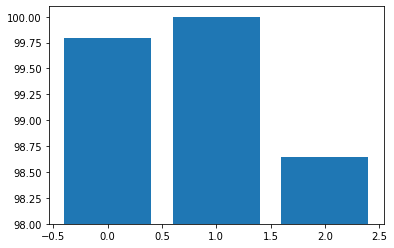

In [91]:
bottom = 98
plt.bar(range(3), [acc - bottom for acc in accuracy_012[:3]], bottom=bottom)
plt.show()

#### Task 2

Now let's take and retrain `features extractor` for the second task.

In [61]:
model_345 = Model(features, output_size=3)

train_model(model_345, 'task2', train_dataloader_345, valid_dataloader_345, num_epochs=5)


Epoch: 5
Loader: train. Accuracy: 0.9944
Loader: valid. Accuracy: 0.9913

Best accuracy:

train: 0.9944
test: 0.9948


In [77]:
accuracy_345 = measure_accuracy(model_345, shift=3)

Accuracy of  0 :  0%
Accuracy of  1 :  0%
Accuracy of  2 :  0%
Accuracy of  3 : 99%
Accuracy of  4 : 100%
Accuracy of  5 : 99%
Accuracy of  6 :  0%
Accuracy of  7 :  0%
Accuracy of  8 :  0%
Accuracy of  9 :  0%


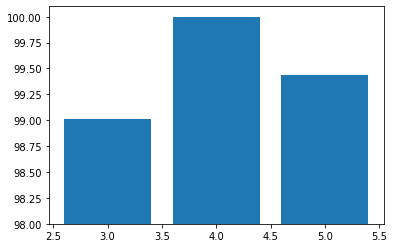

In [89]:
bottom = 98
plt.bar(range(3, 6), [acc - bottom for acc in accuracy_345[3:6]], bottom=bottom)
plt.show()

Let's look at changes in the first model after tunning feature extractor for the second model.

In [80]:
accuracy_012_t2 = measure_accuracy(model_012)

Accuracy of  0 : 99%
Accuracy of  1 : 99%
Accuracy of  2 : 97%
Accuracy of  3 :  0%
Accuracy of  4 :  0%
Accuracy of  5 :  0%
Accuracy of  6 :  0%
Accuracy of  7 :  0%
Accuracy of  8 :  0%
Accuracy of  9 :  0%


As we can see accuracy of the first task fell a little.

It was 100% for the `1` and 98% for the `2`.

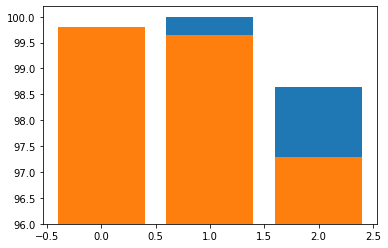

In [105]:
bottom = 96
plt.bar(range(3), [acc - bottom for acc in accuracy_012[:3]], bottom=bottom)
plt.bar(range(3), [acc - bottom for acc in accuracy_012_t2[:3]], bottom=bottom)
plt.show()

#### Task 3

In [92]:
model_6789 = Model(features, output_size=4)

train_model(model_6789, 'task3', train_dataloader_6789, valid_dataloader_6789, num_epochs=5)


Epoch: 5
Loader: train. Accuracy: 0.9894
Loader: valid. Accuracy: 0.9899

Best accuracy:

train: 0.9899
test: 0.9899


In [94]:
accuracy_6789 = measure_accuracy(model_6789, shift=6)

Accuracy of  0 :  0%
Accuracy of  1 :  0%
Accuracy of  2 :  0%
Accuracy of  3 :  0%
Accuracy of  4 :  0%
Accuracy of  5 :  0%
Accuracy of  6 : 99%
Accuracy of  7 : 99%
Accuracy of  8 : 98%
Accuracy of  9 : 97%


Let's look at performace of first and second models after this step.

In [95]:
accuracy_012_t3 = measure_accuracy(model_012)

Accuracy of  0 : 99%
Accuracy of  1 : 96%
Accuracy of  2 : 97%
Accuracy of  3 :  0%
Accuracy of  4 :  0%
Accuracy of  5 :  0%
Accuracy of  6 :  0%
Accuracy of  7 :  0%
Accuracy of  8 :  0%
Accuracy of  9 :  0%


On the previous step accuracy of `1` was 99% and now it is 96%.

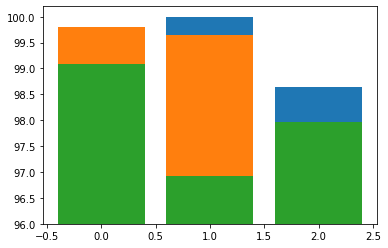

In [108]:
bottom = 96

plt.bar(range(3), [acc - bottom for acc in accuracy_012[:3]], bottom=bottom)
plt.bar(range(3), [acc - bottom for acc in accuracy_012_t2[:3]], bottom=bottom)
plt.bar(range(3), [acc - bottom for acc in accuracy_012_t3[:3]], bottom=bottom)
plt.show()

In [97]:
accuracy_345_t3 = measure_accuracy(model_345, shift=3)

Accuracy of  0 :  0%
Accuracy of  1 :  0%
Accuracy of  2 :  0%
Accuracy of  3 : 99%
Accuracy of  4 : 99%
Accuracy of  5 : 98%
Accuracy of  6 :  0%
Accuracy of  7 :  0%
Accuracy of  8 :  0%
Accuracy of  9 :  0%


On the previous step accuracy of `4` was 100% and accuracy of `5` was 99%.

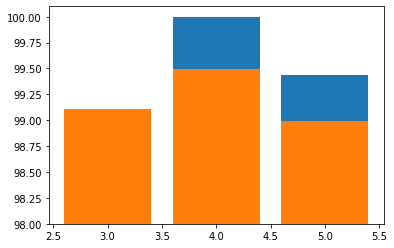

In [110]:
bottom = 98
plt.bar(range(3, 6), [acc - bottom for acc in accuracy_345[3:6]], bottom=bottom)
plt.bar(range(3, 6), [acc - bottom for acc in accuracy_345_t3[3:6]], bottom=bottom)
plt.show()

#### Comparison of models

I will calculate accuracy for all classes using incrementally learned models.

In [102]:
class_correct = np.zeros(10)
class_total = np.zeros(10)

with torch.no_grad():
    for image, label in val_dataset:

        if label in [0, 1, 2]:
            y_pred = model_012(image.unsqueeze(0).to(device))
            _, predicted = torch.max(y_pred, 1)

        elif label in [3, 4, 5]:
            y_pred = model_345(image.unsqueeze(0).to(device))
            _, predicted = torch.max(y_pred, 1)
            predicted += 3

        elif label in [6, 7, 8, 9]:
            y_pred = model_6789(image.unsqueeze(0).to(device))
            _, predicted = torch.max(y_pred, 1)
            predicted += 6


        class_correct[label] += predicted == label
        class_total[label] += 1


for i in range(10):
    print('Accuracy of %2s : %2d%%' % (i, 100 * class_correct[i] / class_total[i]))

accuracy_incremental = [100 * class_correct[i] / class_total[i] for i in range(10)]

Accuracy of  0 : 99%
Accuracy of  1 : 96%
Accuracy of  2 : 97%
Accuracy of  3 : 99%
Accuracy of  4 : 99%
Accuracy of  5 : 98%
Accuracy of  6 : 99%
Accuracy of  7 : 99%
Accuracy of  8 : 98%
Accuracy of  9 : 97%


Let's now comapre performance of incrementally learned models and model from the II.

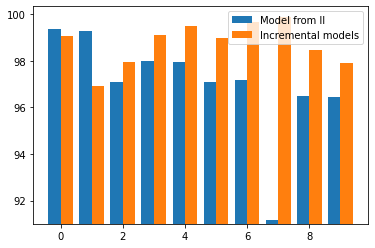

In [120]:
x1 = np.arange(0, 10) - 0.2
x2 = np.arange(0, 10) + 0.2

bottom = 91
plt.bar(x1, [acc - bottom for acc in accuracy], bottom=bottom, width=0.4, label='Model from II')
plt.bar(x2, [acc - bottom for acc in accuracy_incremental], bottom=bottom, width=0.4, label='Incremental models')
plt.legend()
plt.show()

In [122]:
print('Accuracy incremental:', class_correct.sum() / class_total.sum())

Accuracy incremental: 0.9872


Accuracy of the model from II is 0.9702.

### V- Report (2 points)
Write a short report on the results you got and what you learned from this activity

Models that used incrementally learned CNN feature extractor showed better results than general model.

Model from the II task works better on the `0` and `1` classes because this information was forgotten after two additional trainings of CNN.

Other two incremental models work better on all their classes. Such models are like narrow specialists, they are good at solving their smaller tasks. (General model has 91% accuracy for `7` and incremental one has 99%.)

While retraining of CNN for new tasks accuracy on previous ones slightly became worse but not that much.

